In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv(r"C:\Users\santh\Downloads\delhiaqi.csv")

In [5]:
print(data.head())

                  date       co     no    no2    o3    so2   pm2_5    pm10  \
0  2023-01-01 00:00:00  1655.58   1.66  39.41  5.90  17.88  169.29  194.64   
1  2023-01-01 01:00:00  1869.20   6.82  42.16  1.99  22.17  182.84  211.08   
2  2023-01-01 02:00:00  2510.07  27.72  43.87  0.02  30.04  220.25  260.68   
3  2023-01-01 03:00:00  3150.94  55.43  44.55  0.85  35.76  252.90  304.12   
4  2023-01-01 04:00:00  3471.37  68.84  45.24  5.45  39.10  266.36  322.80   

     nh3  
0   5.83  
1   7.66  
2  11.40  
3  13.55  
4  14.19  


In [70]:
# Renaming the column pm2_5 to pm2.5(particle matter) for better readability
data.rename(columns={'pm2_5': 'pm2.5'}, inplace=True)

In [18]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

# Fill or drop missing values as needed (example: forward fill method)
data.ffill(inplace=True)

Missing values:
 date       0
co         0
no         0
no2        0
o3         0
so2        0
pm2.5      0
pm10       0
nh3        0
day        0
hour       0
weekday    0
dtype: int64


In [19]:
# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Extract day, hour, weekday from the date
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday

In [71]:
# Descriptive statistics
desc_stats = data[data.columns[:-3]].describe()
print("Descriptive Statistics:\n", desc_stats)

Descriptive Statistics:
                       date            co          no         no2          o3  \
count                  561    561.000000  561.000000  561.000000  561.000000   
mean   2023-01-12 16:00:00   3814.942210   51.181979   75.292496   30.141943   
min    2023-01-01 00:00:00    654.220000    0.000000   13.370000    0.000000   
25%    2023-01-06 20:00:00   1708.980000    3.380000   44.550000    0.070000   
50%    2023-01-12 16:00:00   2590.180000   13.300000   63.750000   11.800000   
75%    2023-01-18 12:00:00   4432.680000   59.010000   97.330000   47.210000   
max    2023-01-24 08:00:00  16876.220000  425.580000  263.210000  164.510000   
std                    NaN   3227.744681   83.904476   42.473791   39.979405   

              so2        pm2.5         pm10         nh3         day  
count  561.000000   561.000000   561.000000  561.000000  561.000000  
mean    64.655936   358.256364   420.988414   26.425062   12.192513  
min      5.250000    60.100000    69.080000 

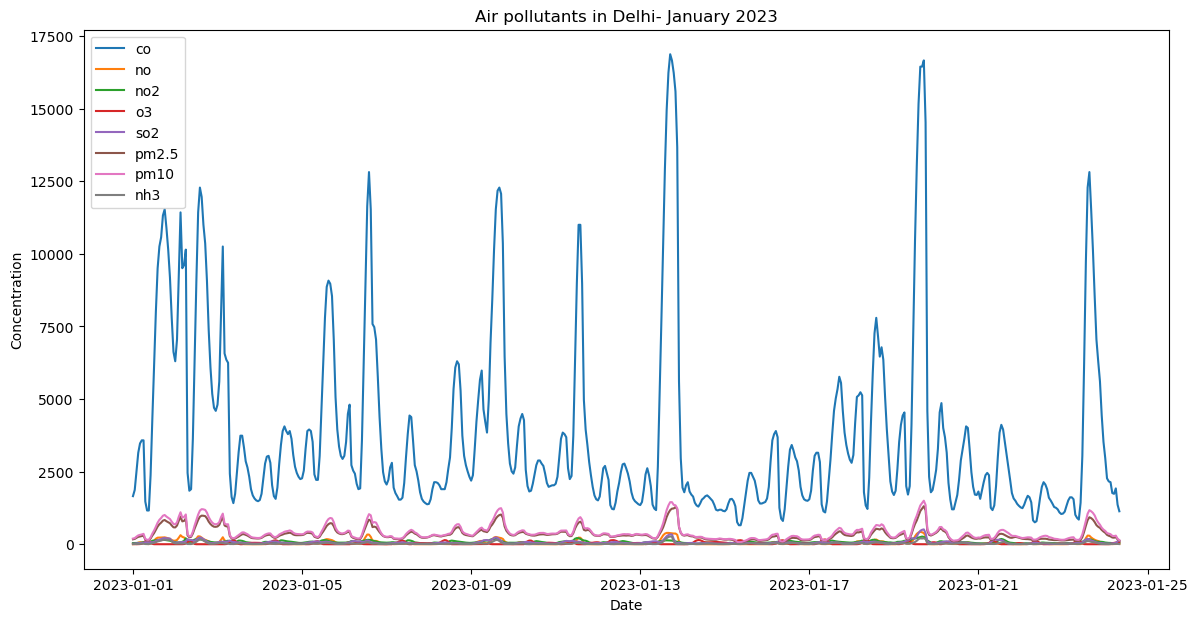

In [23]:
# Plot time series for each pollutant
plt.figure(figsize=(14, 7))
for column in  ['co', 'no', 'no2', 'o3', 'so2', 'pm2.5', 'pm10', 'nh3']:
    plt.plot(data.date, data[column], label=column)

plt.xlabel('Date')
plt.ylabel('Concentration')
plt.title('Air pollutants in Delhi- January 2023')
plt.legend()
plt.show()


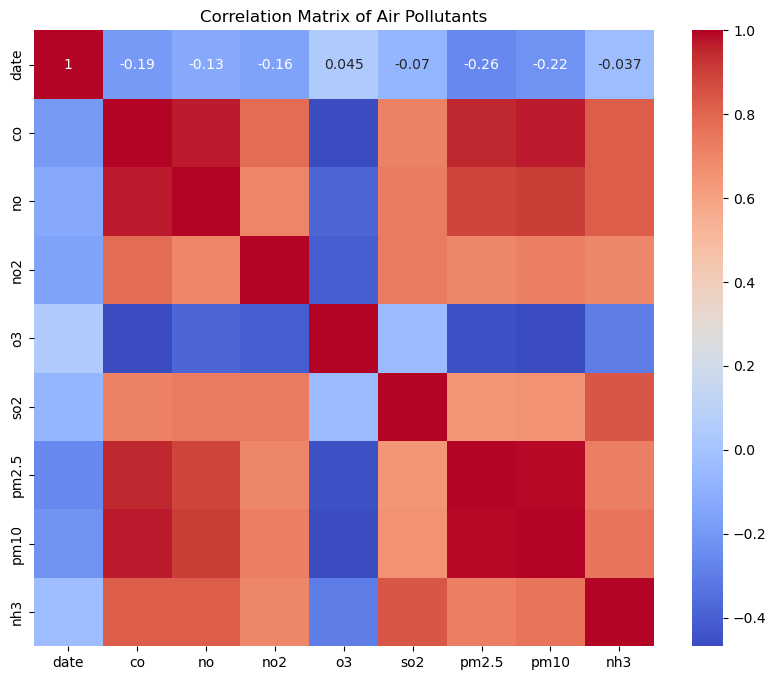

In [27]:
# Correlation matrix
correlation_matrix = data[data.columns[:-3]].corr()

# Heatmap of correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Air Pollutants')
plt.show()

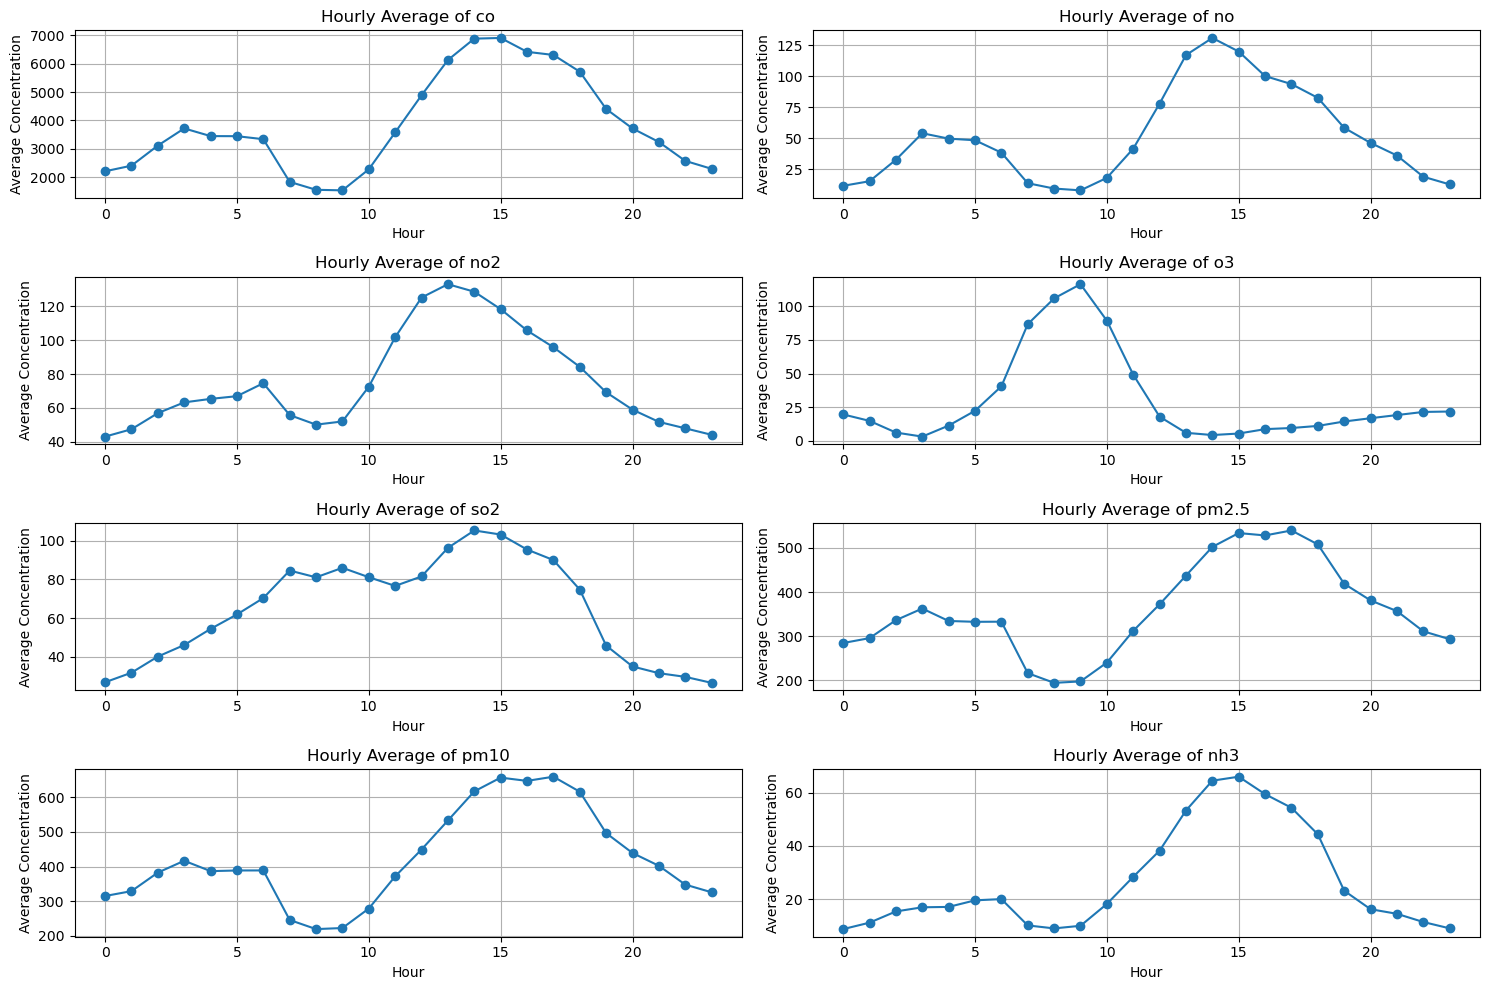

In [26]:
# Compute hourly averages
hourly_avg = data.groupby('hour').mean()

# Plot hourly averages for each pollutant
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns[1:-3], 1):  # Skipping the 'date' and extracted columns, and 'day', 'hour', 'weekday'
    plt.subplot(4, 2, i)
    plt.plot(hourly_avg.index, hourly_avg[col], marker='o')
    plt.title(f'Hourly Average of {col}')
    plt.xlabel('Hour')
    plt.ylabel('Average Concentration')
    plt.grid(True)

plt.tight_layout()
plt.show()

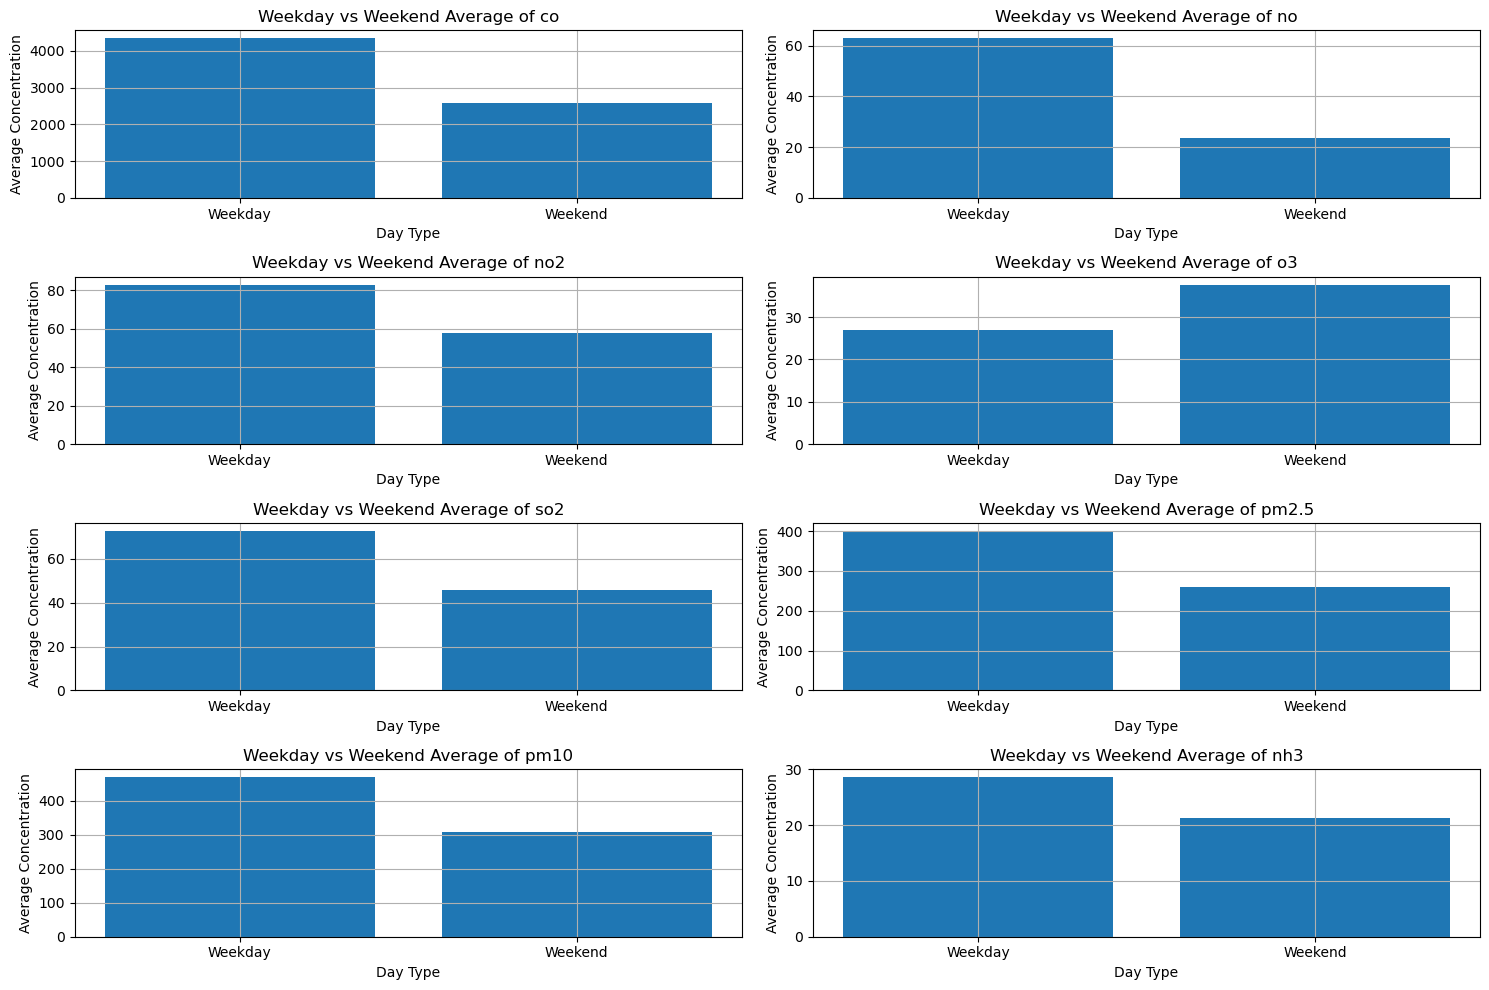

In [34]:
# Create a 'weekend' column (1 if weekend, 0 if weekday)
data['weekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Compute averages for weekdays and weekends
weekend_avg = data.groupby('weekend').mean()

# Plot comparison
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns[1:-4], 1):  # Skipping the 'date' and extracted columns, and 'day', 'hour', 'weekday', 'weekend'
    plt.subplot(4, 2, i)
    plt.bar(['Weekday', 'Weekend'], weekend_avg[col])
    plt.title(f'Weekday vs Weekend Average of {col}')
    plt.xlabel('Day Type')
    plt.ylabel('Average Concentration')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [79]:
aqi_standards = {
    'co': 10 * 1000,    # CO (10 mg/m³ converted to ppb)
    'no': 40,           # NO (ppb, approximate guideline)
    'no2': 40,          # NO2 (ppb)
    'o3': 50,           # O3 (ppb)
    'so2': 40,          # SO2 (ppb)
    'pm2.5': 60,        # PM2.5 (µg/m³)
    'pm10': 100,        # PM10 (µg/m³)
    'nh3': 400          # NH3 (ppb)
}

# Calculate exceedances
exceedances = data.copy()
for col in aqi_standards:
    exceedances[col] = data[col] - aqi_standards[col]

# Clip negative values to 0 (indicating no exceedance)
exceedances.iloc[:, 1:-4] = exceedances.iloc[:, 1:-4].clip(lower=0)

# Calculate percentage exceedance
percentage_exceedances = (exceedances.iloc[:, 1:9] / pd.Series(aqi_standards)) * 100

# Display the first few rows of exceedances
print(exceedances.head())
print(percentage_exceedances.head())

                 date   co     no   no2   o3  so2   pm2.5    pm10  nh3  day  \
0 2023-01-01 00:00:00  0.0   0.00  0.00  0.0  0.0  109.29   94.64  0.0    1   
1 2023-01-01 01:00:00  0.0   0.00  2.16  0.0  0.0  122.84  111.08  0.0    1   
2 2023-01-01 02:00:00  0.0   0.00  3.87  0.0  0.0  160.25  160.68  0.0    1   
3 2023-01-01 03:00:00  0.0  15.43  4.55  0.0  0.0  192.90  204.12  0.0    1   
4 2023-01-01 04:00:00  0.0  28.84  5.24  0.0  0.0  206.36  222.80  0.0    1   

   hour  weekday  weekend  
0     0        6        1  
1     1        6        1  
2     2        6        1  
3     3        6        1  
4     4        6        1  
    co      no     no2   o3  so2       pm2.5    pm10  nh3
0  0.0   0.000   0.000  0.0  0.0  182.150000   94.64  0.0
1  0.0   0.000   5.400  0.0  0.0  204.733333  111.08  0.0
2  0.0   0.000   9.675  0.0  0.0  267.083333  160.68  0.0
3  0.0  38.575  11.375  0.0  0.0  321.500000  204.12  0.0
4  0.0  72.100  13.100  0.0  0.0  343.933333  222.80  0.0


<Figure size 1000x600 with 0 Axes>

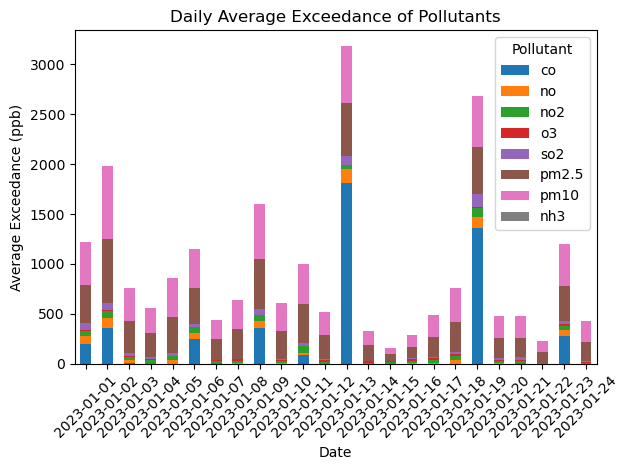

In [81]:
# Convert 'date' column to datetime type
data['date'] = pd.to_datetime(data['date'])

# Group by date and calculate the mean exceedance for each pollutant
daily_exceedance_mean =exceedances.groupby(data['date'].dt.date).mean()

# Plotting
plt.figure(figsize=(10, 6))
daily_exceedance_mean.iloc[:, 1:-4].plot(kind='bar', stacked=True)
plt.title('Daily Average Exceedance of Pollutants')
plt.xlabel('Date')
plt.ylabel('Average Exceedance (ppb)')
plt.xticks(rotation=45)
plt.legend(title='Pollutant')
plt.tight_layout()
plt.show()
